#Machine Learning Mini Project 1 - Satu Laukkanen
This project has been coded in Google Colab

##Imports

In [51]:
import csv
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

Please add your own file path to the code before running.

In [52]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Machine Learning/Mini Project 1/rawdata'
files = os.listdir(folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['starboardPitch.csv', 'portPitch.csv', 'starboardRudder.csv', 'portRudder.csv', 'trackDegreeTrue.csv', 'speedKmh.csv', 'windAngle.csv', 'level2median.csv', 'trueHeading.csv', 'level1median.csv', 'windSpeed.csv', 'speedKnots.csv', 'longitudinalWaterSpeed.csv', 'inclinometer-raw.csv', 'trackDegreeMagnetic.csv', 'fuelTemp.csv', 'fuelDensity.csv', 'fuelVolumeFlowRate.csv', 'longitude.csv', 'latitude.csv', 'fuelVolumeFlowRate (1).gsheet', 'windAngle.gsheet', 'fuelTemp.gsheet', 'inclinometer-raw.gsheet', 'fuelVolumeFlowRate.gsheet']


##Data Processing#

At this point, longitudes and latitudes are dropped as they are not of numerical value.

In [53]:
fuel_density = pd.read_csv(folder_path + '/fuelDensity.csv', header=None, names=["timestamp", "fuelDensity"])
fuel_temp = pd.read_csv(folder_path + '/fuelTemp.csv', header=None, names=["timestamp", "fuelTemp"])
fuel_volume_flow_rate = pd.read_csv(folder_path + '/fuelVolumeFlowRate.csv', header=None, names=["timestamp", "fuelVolumeFlowRate"])
inclinometer_raw = pd.read_csv(folder_path + '/inclinometer-raw.csv', header=None, names=["timestamp", "inclinometerRaw"])
#latitude = pd.read_csv(folder_path + '/latitude.csv', header=None, names=["timestamp", "latitude"])
#longitude = pd.read_csv(folder_path + '/longitude.csv', header=None, names=["timestamp", "longitude"])
level1median = pd.read_csv(folder_path + '/level1median.csv', header=None, names=["timestamp", "level1median"])
level2median = pd.read_csv(folder_path + '/level2median.csv', header=None, names=["timestamp", "level2median"])
longitudinal_water_speed = pd.read_csv(folder_path + '/longitudinalWaterSpeed.csv', header=None, names=["timestamp", "longitudinalWaterSpeed"])
port_pitch = pd.read_csv(folder_path + '/portPitch.csv', header=None, names=["timestamp", "portPitch"])
port_rudder = pd.read_csv(folder_path + '/portRudder.csv', header=None, names=["timestamp", "portRudder"])
speed_kmh = pd.read_csv(folder_path + '/speedKmh.csv', header=None, names=["timestamp", "speedKmh"])
speed_knots = pd.read_csv(folder_path + '/speedKnots.csv', header=None, names=["timestamp", "speedKnots"])
starboard_pitch = pd.read_csv(folder_path + '/starboardPitch.csv', header=None, names=["timestamp", "starboardPitch"])
starboard_rudder = pd.read_csv(folder_path + '/starboardRudder.csv', header=None, names=["timestamp", "starboardRudder"])
track_degree_magnetic = pd.read_csv(folder_path + '/trackDegreeMagnetic.csv', header=None, names=["timestamp", "trackDegreeMagnetic"])
track_degree_true = pd.read_csv(folder_path + '/trackDegreeTrue.csv', header=None, names=["timestamp", "trackDegreeTrue"])
true_heading = pd.read_csv(folder_path + '/trueHeading.csv', header=None, names=["timestamp", "trueHeading"])
wind_angle = pd.read_csv(folder_path + '/windAngle.csv', header=None, names=["timestamp", "windAngle"])
wind_speed = pd.read_csv(folder_path + '/windSpeed.csv', header=None, names=["timestamp", "windSpeed"])

A list is made of the non-fuel related dataframes for later merging.

In [54]:
dfs = [
    inclinometer_raw,
    level1median, level2median, longitudinal_water_speed, port_pitch, port_rudder, speed_kmh,
    speed_knots, starboard_pitch, starboard_rudder, track_degree_magnetic, track_degree_true,
    true_heading, wind_angle, wind_speed
]

As the fuel-related systems have the same sensoring intervals, they are merged into a single data frame based on the timestamp. Columns where fuel volume density is 0 are dropped at this point, as it will make our target value EC zero.

In [55]:
df = pd.merge(fuel_density, fuel_temp, on='timestamp')
df = pd.merge(df, fuel_volume_flow_rate, on='timestamp')

#dropping rows where EC will be 0
df = df[df["fuelVolumeFlowRate"] != 0]


df

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate
4,634019212935606850,0.938305,86.89216,0.283816
5,634019212945820680,0.938173,87.08717,0.279202
6,634019212956034910,0.938036,87.22346,0.282821
7,634019212966268860,0.937983,87.32133,0.280900
8,634019212976492840,0.937767,87.53302,0.279850
...,...,...,...,...
1627319,634067079121428610,0.930151,96.70869,0.203576
1627320,634067079131642650,0.930103,96.75071,0.205217
1627321,634067079141866640,0.930075,96.76398,0.212853
1627322,634067079152080710,0.930082,96.76657,0.224660


All dataframes in the dfs-list and the fuel dataframe are sorted based on their timestamps.

In [56]:
df = df.sort_values("timestamp")

for i in range(len(dfs)):
    dfs[i] = dfs[i].sort_values("timestamp")

df

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate
4,634019212935606850,0.938305,86.89216,0.283816
5,634019212945820680,0.938173,87.08717,0.279202
6,634019212956034910,0.938036,87.22346,0.282821
7,634019212966268860,0.937983,87.32133,0.280900
8,634019212976492840,0.937767,87.53302,0.279850
...,...,...,...,...
1627319,634067079121428610,0.930151,96.70869,0.203576
1627320,634067079131642650,0.930103,96.75071,0.205217
1627321,634067079141866640,0.930075,96.76398,0.212853
1627322,634067079152080710,0.930082,96.76657,0.224660


Merge_asof is used for mergeing the dataframes, based on the nearest proximity to the existing fuelbased dataframe.

In [57]:
for d in dfs:
    df = pd.merge_asof(df, d, on="timestamp", direction="nearest", suffixes=("", "_dup"))

#drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

An estimation of the daily fuel consumption is added as it's own column. It's an estimation of the daily energy consumption in the given moment features were measured.

In [58]:
df["EC"] = (df["fuelDensity"] * df["fuelVolumeFlowRate"] * 3600 * 24) / 1000

df

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometerRaw,level1median,level2median,longitudinalWaterSpeed,portPitch,portRudder,speedKmh,speedKnots,starboardPitch,starboardRudder,trackDegreeMagnetic,trackDegreeTrue,trueHeading,windAngle,windSpeed,EC
0,634019212935606850,0.938305,86.89216,0.283816,357.23,16.726154,14.661420,0.1,-0.029,0.086,1.1,0.6,0.034,8.538,238.8,231.6,166.29,273,13.0,23.008844
1,634019212945820680,0.938173,87.08717,0.279202,357.23,16.708345,14.403350,0.1,-0.029,0.086,1.1,0.6,0.034,8.538,238.8,231.6,166.29,273,13.0,22.631633
2,634019212956034910,0.938036,87.22346,0.282821,357.23,16.850815,14.229599,0.1,-0.040,0.087,1.1,0.6,0.040,8.535,237.7,230.5,167.05,271,13.2,22.921554
3,634019212966268860,0.937983,87.32133,0.280900,357.23,16.787212,14.201493,0.2,-0.019,0.089,1.5,0.8,0.244,8.537,236.4,229.2,168.07,271,13.2,22.764660
4,634019212976492840,0.937767,87.53302,0.279850,357.23,17.046712,14.147834,0.2,-0.017,0.085,1.5,0.8,0.566,8.538,236.4,229.2,168.74,294,12.6,22.674334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627246,634067079121428610,0.930151,96.70869,0.203576,357.25,16.787212,14.099287,-0.2,0.740,-8.151,0.9,0.5,0.784,8.531,171.3,164.3,318.19,357,2.2,16.360387
1627247,634067079131642650,0.930103,96.75071,0.205217,357.26,16.766860,14.055849,-0.2,1.123,-8.152,0.9,0.5,1.216,8.534,171.3,164.3,318.02,357,2.2,16.491431
1627248,634067079141866640,0.930075,96.76398,0.212853,357.28,16.810110,14.066070,-0.2,1.574,-8.147,0.9,0.5,1.579,8.534,171.9,164.9,317.93,0,2.2,17.104559
1627249,634067079152080710,0.930082,96.76657,0.224660,357.29,16.787212,14.066070,-0.2,2.019,-8.149,0.9,0.5,2.036,8.532,171.9,164.9,317.83,0,2.2,18.053494


There are no NaN fields in the data frame.

In [59]:
#check NaN in df
df.isna().sum()

,0
timestamp,0
fuelDensity,0
fuelTemp,0
fuelVolumeFlowRate,0
inclinometerRaw,0
level1median,0
level2median,0
longitudinalWaterSpeed,0
portPitch,0
portRudder,0


A correlation heatmap based on Pearson. As we can see, fuelVolumeFlowRate has a 1.0 correlation with the target variable EC. Among other highly correlating features we can find speed, pitch and rudder related features.

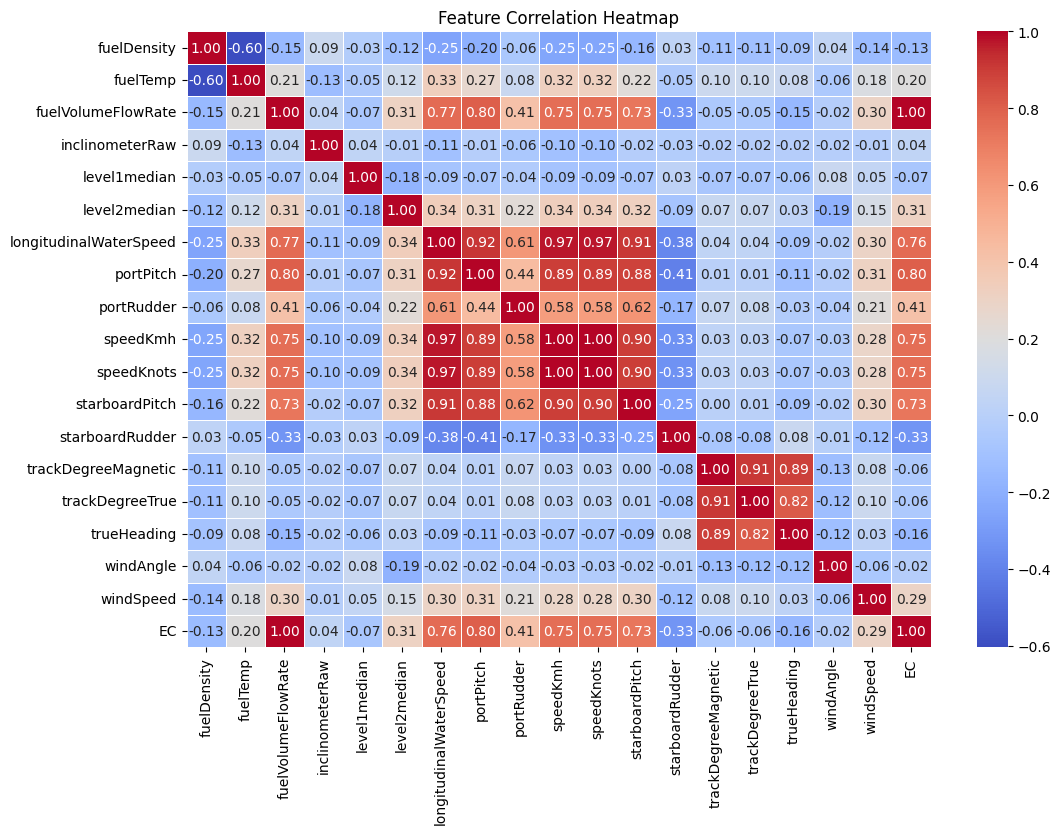

In [60]:
#Correlation heat map for EC
correlation_matrix = df.drop(columns=["timestamp"]).corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation Heatmap")
plt.show()

The .NET tick timestamp is conerted to a datetime format and added as an index to the dataframe.

In [61]:
df["timestamp"] = pd.to_numeric(df["timestamp"], errors="coerce")

#.NET ticks to datetime
df["datetime"] = pd.to_datetime(df["timestamp"] // 10**7 - 62135596800, unit="s")

df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")  #set as index

df

,timestamp,fuelDensity,fuelTemp,fuelVolumeFlowRate,inclinometerRaw,level1median,level2median,longitudinalWaterSpeed,portPitch,portRudder,speedKmh,speedKnots,starboardPitch,starboardRudder,trackDegreeMagnetic,trackDegreeTrue,trueHeading,windAngle,windSpeed,EC
datetime,,,,,,,,,,,,,,,,,,,,
2010-02-16 12:48:13,634019212935606850,0.938305,86.89216,0.283816,357.23,16.726154,14.661420,0.1,-0.029,0.086,1.1,0.6,0.034,8.538,238.8,231.6,166.29,273,13.0,23.008844
2010-02-16 12:48:14,634019212945820680,0.938173,87.08717,0.279202,357.23,16.708345,14.403350,0.1,-0.029,0.086,1.1,0.6,0.034,8.538,238.8,231.6,166.29,273,13.0,22.631633
2010-02-16 12:48:15,634019212956034910,0.938036,87.22346,0.282821,357.23,16.850815,14.229599,0.1,-0.040,0.087,1.1,0.6,0.040,8.535,237.7,230.5,167.05,271,13.2,22.921554
2010-02-16 12:48:16,634019212966268860,0.937983,87.32133,0.280900,357.23,16.787212,14.201493,0.2,-0.019,0.089,1.5,0.8,0.244,8.537,236.4,229.2,168.07,271,13.2,22.764660
2010-02-16 12:48:17,634019212976492840,0.937767,87.53302,0.279850,357.23,17.046712,14.147834,0.2,-0.017,0.085,1.5,0.8,0.566,8.538,236.4,229.2,168.74,294,12.6,22.674334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-12 22:25:12,634067079121428610,0.930151,96.70869,0.203576,357.25,16.787212,14.099287,-0.2,0.740,-8.151,0.9,0.5,0.784,8.531,171.3,164.3,318.19,357,2.2,16.360387
2010-04-12 22:25:13,634067079131642650,0.930103,96.75071,0.205217,357.26,16.766860,14.055849,-0.2,1.123,-8.152,0.9,0.5,1.216,8.534,171.3,164.3,318.02,357,2.2,16.491431
2010-04-12 22:25:14,634067079141866640,0.930075,96.76398,0.212853,357.28,16.810110,14.066070,-0.2,1.574,-8.147,0.9,0.5,1.579,8.534,171.9,164.9,317.93,0,2.2,17.104559


The daily mean EC is calculated and plotted. As seen in the plot, not all days have measuring data.

In [62]:
#daily mean EC
df_daily = df.resample("D")["EC"].mean().reset_index()

In [63]:
df_daily

,datetime,EC
0,2010-02-16,38.914119
1,2010-02-17,49.363946
2,2010-02-18,50.574300
3,2010-02-19,46.518224
4,2010-02-20,50.139800
5,2010-02-21,50.760900
6,2010-02-22,47.287144
7,2010-02-23,45.517821
8,2010-02-24,49.427420
9,2010-02-25,49.908960


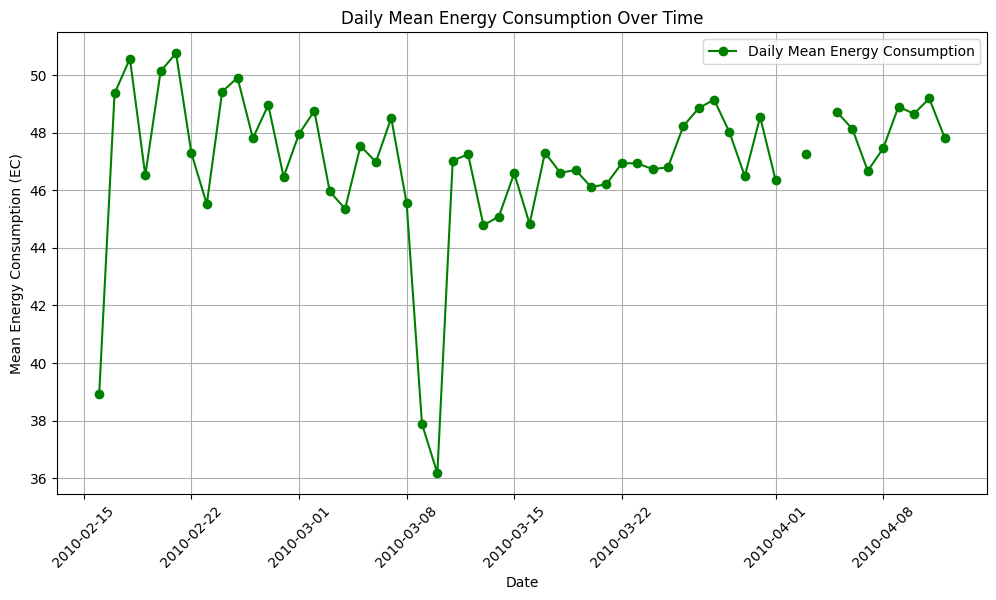

In [64]:
# Plot daily mean EC
plt.figure(figsize=(12,6))
plt.plot(df_daily["datetime"], df_daily["EC"], label="Daily Mean Energy Consumption", color="green", marker="o", linestyle="-")

plt.xlabel("Date")
plt.ylabel("Mean Energy Consumption (EC)")
plt.title("Daily Mean Energy Consumption Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [65]:
#drop NaN days
df_daily = df_daily.dropna()

#mean for consumption on day
df_daily["EC"].mean()

46.97707352640204

Below, a chart that show average fuel consumption over the hours of a day.

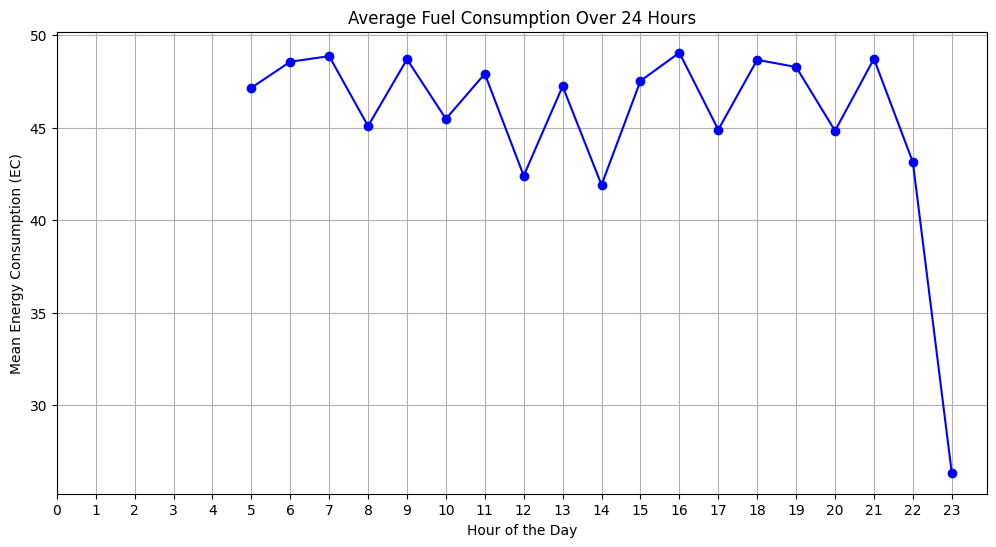

In [66]:
df = df.reset_index()

df["hour"] = df["datetime"].dt.hour  # Extract hour (0-23)

df_hourly = df.groupby("hour")["EC"].mean().reset_index()

plt.figure(figsize=(12,6))
plt.plot(df_hourly["hour"], df_hourly["EC"], marker="o", linestyle="-", color="blue")

plt.xlabel("Hour of the Day")
plt.ylabel("Mean Energy Consumption (EC)")
plt.title("Average Fuel Consumption Over 24 Hours")
plt.xticks(range(0, 24))  # Ensure all hours (0-23) are labeled
plt.grid()
plt.show()

###Final DF for training

A final dataframe is created. The "fuelDensity", "fuelTemp", "fuelVolumeFlowRate", "hour", "inclinometerRaw", "level1median", "level2median", "datetime", "speedKmh", "trackDegreeMagnetic", "trackDegreeTrue", "trueHeading", "windAngle", and "timestamp" features are dropped based on lacking or too high correlation. All fuel-related features are dropped aswell, as fuelVolumeFlowRate has a 1.0 correlation with the target EC.

Some features, such as speed in km/h are dropped because of correlation to other features, such as knot speed.

In [67]:
cols_to_drop = [
    "fuelDensity", "fuelTemp", "fuelVolumeFlowRate", "hour",
    "inclinometerRaw", "level1median", "level2median", "datetime",
    "speedKmh", "trackDegreeMagnetic",
    "trackDegreeTrue", "trueHeading", "windAngle", "timestamp", "windSpeed"
]

df_test = df.drop(columns=cols_to_drop)

df_test

,longitudinalWaterSpeed,portPitch,portRudder,speedKnots,starboardPitch,starboardRudder,EC
0,0.1,-0.029,0.086,0.6,0.034,8.538,23.008844
1,0.1,-0.029,0.086,0.6,0.034,8.538,22.631633
2,0.1,-0.040,0.087,0.6,0.040,8.535,22.921554
3,0.2,-0.019,0.089,0.8,0.244,8.537,22.764660
4,0.2,-0.017,0.085,0.8,0.566,8.538,22.674334
...,...,...,...,...,...,...,...
1627246,-0.2,0.740,-8.151,0.5,0.784,8.531,16.360387
1627247,-0.2,1.123,-8.152,0.5,1.216,8.534,16.491431
1627248,-0.2,1.574,-8.147,0.5,1.579,8.534,17.104559
1627249,-0.2,2.019,-8.149,0.5,2.036,8.532,18.053494


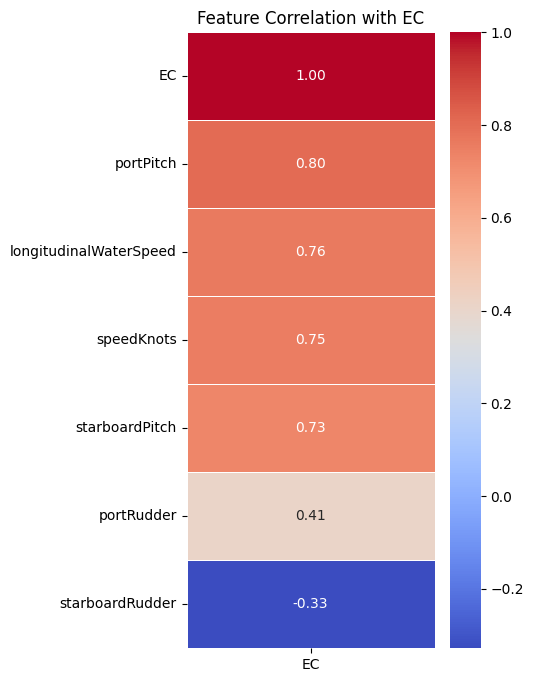

In [68]:
correlation_matrix = df_test.corr()

ec_correlation = correlation_matrix[["EC"]].sort_values(by="EC", ascending=False)

plt.figure(figsize=(4, 8))
sns.heatmap(ec_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Feature Correlation with EC")
plt.show()

##Creating test and training sets

When creating training, validation, and test sets, a choice between using randomized split and date-based split was made. In stead of splitting the data set into different portions based on never before seen date data, randomization was chosen.

As the training, testing and validation sets do not include the timestamps or datetime features, but predict based on sensor data in an isolated moment, randomization works.

In [69]:
#separation of features and target
X = df_test.drop(columns=["EC"])
y = df_test["EC"]

#Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) #70/30
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #15/15

print(f"Sizes of the sets: Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")


Sizes of the sets: Train: 1139075, Validation: 244088, Test: 244088


##Machine Learning Models

As this Linear Regression performance is lacking, three models were chosen be evaluated, in order to achieve over 85% prediction accuracy.

###Linear Regression

I wanted to experiment with an easier model at the beginning of the analysis. Features are scaled at the beginning of the analysis for improved model predictions.

In [70]:
#scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#train
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

In [71]:
#validation set
y_val_pred = lr.predict(X_val_scaled)

r2_val_lr = r2_score(y_val, y_val_pred)
mse_val_lr = mean_squared_error(y_val, y_val_pred)
rmse_val_lr = np.sqrt(mse_val_lr)

print(f"R² (val): {r2_val_lr}")
print(f"MSE (val): {mse_val_lr}")
print(f"RMSE (val): {rmse_val_lr}")

R² (val): 0.6506106658890998
MSE (val): 31.956124095200966
RMSE (val): 5.65297480050999


In [72]:
#test set
y_test_pred = lr.predict(X_test_scaled)

r2_test_lr = r2_score(y_test, y_test_pred)
mse_test_lr = mean_squared_error(y_test, y_test_pred)
rmse_test_lr = np.sqrt(mse_test_lr)

print(f"R² (test): {r2_test_lr}")
print(f"MSE (test): {mse_test_lr}")
print(f"RMSE (test): {rmse_test_lr}")

R² (test): 0.6525787884077321
MSE (test): 31.492719383328716
RMSE (test): 5.611837433793741


In [73]:
results_df = pd.DataFrame({
    "Model": ["Linear Regression"],
    "R² (val)": [r2_val_lr],
    "RMSE (val)": [rmse_val_lr],
    "R² (test)": [r2_test_lr],
    "RMSE (test)": [rmse_test_lr]
})

results_df

,Model,R² (val),RMSE (val),R² (test),RMSE (test)
0,Linear Regression,0.650611,5.652975,0.652579,5.611837


As we can see, the linear regression prediction accuracy is not very high, about 0.65.

###Polynomial Regression

As a second model, Polynomial Regression is explored.

In [74]:
#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#features are transformed
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

#train
pr_poly = LinearRegression()
pr_poly.fit(X_train_poly, y_train)


LinearRegression()

In [75]:
#validation set
y_val_pred = pr_poly.predict(X_val_poly)

r2_val_pr = r2_score(y_val, y_val_pred)
mse_val_pr = mean_squared_error(y_val, y_val_pred)
rmse_val_pr = np.sqrt(mse_val_pr)

print(f"R² (val): {r2_val_pr}")
print(f"MSE (val): {mse_val_pr}")
print(f"RMSE (val): {rmse_val_pr}")

R² (val): 0.9465611970740202
MSE (val): 4.887662132409448
RMSE (val): 2.2108057654189


In [76]:
#training set
y_test_pred = pr_poly.predict(X_test_poly)

r2_test_pr = r2_score(y_test, y_test_pred)
mse_test_pr = mean_squared_error(y_test, y_test_pred)
rmse_test_pr = np.sqrt(mse_test_pr)

print(f"R² (test): {r2_test_pr}")
print(f"MSE (test): {mse_test_pr}")
print(f"RMSE (test): {rmse_test_pr}")

R² (test): 0.9466451306665943
MSE (test): 4.8364632658730695
RMSE (test): 2.1991960498948404


In [77]:
results_df = pd.DataFrame({
    "Model": ["Polynomial Regression"],
    "R² (val)": [r2_val_pr],
    "RMSE (val)": [rmse_val_pr],
    "R² (test)": [r2_test_pr],
    "RMSE (test)": [rmse_test_pr]
})

results_df

,Model,R² (val),RMSE (val),R² (test),RMSE (test)
0,Polynomial Regression,0.946561,2.210806,0.946645,2.199196


As we can see, Polynomial Regression is performing much better with an average of 0.94 accuracy.

###Random Forest Regressor

Random Forest Regression is more time consuming than the former simpler models. Training it with Colab Pro takes about 6 minutes, so please have patience.

In [78]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [79]:
#validation set
y_val_pred = rf.predict(X_val)

r2_val_rf = r2_score(y_val, y_val_pred)
mse_val_rf = mean_squared_error(y_val, y_val_pred)
rmse_val_rf = np.sqrt(mse_val_rf)

print(f"R² (val): {r2_val_rf}")
print(f"MSE (val): {mse_val_rf}")
print(f"RMSE (val): {rmse_val_rf}")

R² (val): 0.9601254819380913
MSE (val): 3.6470347632828104
RMSE (val): 1.9097211218612027


In [80]:
#test set
y_test_pred = rf.predict(X_test)

r2_test_rf = r2_score(y_test, y_test_pred)
mse_test_rf = mean_squared_error(y_test, y_test_pred)
rmse_test_rf = np.sqrt(mse_test_rf)

print(f"R² (test): {r2_test_rf}")
print(f"MSE (test): {mse_test_rf}")
print(f"RMSE (test): {rmse_test_rf}")

R² (test): 0.9600041279958461
MSE (test): 3.625509126934333
RMSE (test): 1.90407697505493


In [81]:
results_df = pd.DataFrame({
    "Model": ["Random Forest"],
    "R² (val)": [r2_val_rf],
    "RMSE (val)": [rmse_val_rf],
    "R² (test)": [r2_test_rf],
    "RMSE (test)": [rmse_test_rf]
})

results_df

,Model,R² (val),RMSE (val),R² (test),RMSE (test)
0,Random Forest,0.960125,1.909721,0.960004,1.904077


Random Forest Regression has an even higher performance average of 0.96.

##Model Comparisons

In [82]:
results = []

results.append({
    "Model": "Random Forest",
    "R² (val)": r2_val_rf,
    "RMSE (val)": rmse_val_rf,
    "R² (test)": r2_test_rf,
    "RMSE (test)": rmse_test_rf
})

results.append({
    "Model": "Polynomial Regression",
    "R² (val)": r2_val_pr,
    "RMSE (val)": rmse_val_pr,
    "R² (test)": r2_test_pr,
    "RMSE (test)": rmse_test_pr
})

results.append({
    "Model": "Linear Regression",
    "R² (val)": r2_val_lr,
    "RMSE (val)": rmse_val_lr,
    "R² (test)": r2_test_lr,
    "RMSE (test)": rmse_test_lr
})

results_df = pd.DataFrame(results)

results_df

,Model,R² (val),RMSE (val),R² (test),RMSE (test)
0,Random Forest,0.960125,1.909721,0.960004,1.904077
1,Polynomial Regression,0.946561,2.210806,0.946645,2.199196
2,Linear Regression,0.650611,5.652975,0.652579,5.611837


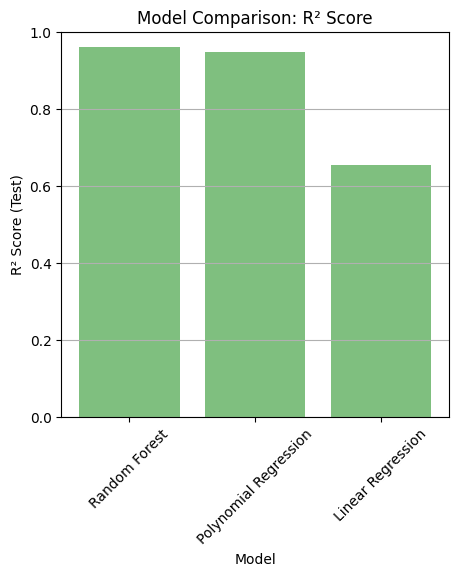

In [83]:
results_df = results_df.sort_values(by="R² (test)", ascending=False)

plt.figure(figsize=(5, 5))
plt.bar(results_df["Model"], results_df["R² (test)"], color="green", alpha=0.5)

plt.xlabel("Model")
plt.ylabel("R² Score (Test)")
plt.title("Model Comparison: R² Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.show()


Both Random Forest and Polynomial Regression perform well compared to Linear Regression.